In [90]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


sklearn version:  1.2.2


C:\Users\LG\anaconda3\envs\add\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TF version:  2.12.0
No GPU was detected. CNNs can be very slow without a GPU.
GPU installed:  False


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, GlobalAveragePooling2D, MaxPooling2D, Add,  Dense, Conv2D, Activation
from keras.models import Sequential

In [5]:
def pd_plot(data_pd):
    for i in range(10):
        for j in range(10):
            plt.subplot(10, 10, j+1)
            plt.imshow(np.array(data_pd.iloc[10*i+j]).reshape(28,28),cmap='gray')
        plt.show()

# 가. MNIST extended dataset 개요 및 분석

## 1-1) byclass 

### data_load

#### byclass_pd_train=pd.read_csv('emnist-byclass-train.csv',header=None)
#### byclass_pd_test=pd.read_csv('emnist-byclass-test.csv',header=None)

#### 코랩상에서 돌릴시 메모리 부족으로 kernel이 죽는 문제 발생 -> tensorflow_datasets의 data로 시도

In [33]:
import tensorflow_datasets as tfds
((x_train,y_train), (x_test,y_test)), ds_info=tfds.load('emnist/byclass',split=['train','test'],with_info=True,as_supervised=True,batch_size=-1)
label_map = pd.read_csv("emnist-byclass-mapping.txt", delimiter = ' ', index_col=0, header=None).squeeze('columns')

### 데이터 구성 확인

In [3]:
print(ds_info)

tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/byclass/3.0.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST ByClass
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_path='C:\\Users\\LG\\tensorflow_datasets\\emnist\\byclass\\3.0.0',
    file_format=tfrecord,
    download_size=535.73 MiB,
    dataset_size=349.16 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=62),
    }),
    s

### 데이테 형태
#### 'image': Image(shape=(28, 28, 1), dtype=uint8), => 28,28,1의 shape를 가짐
#### 'label': ClassLabel(shape=(), dtype=int64, num_classes=62) => 62개의 class
#### train : 697932 개
#### test : 116323개

### class 별 갯수

<BarContainer object of 62 artists>

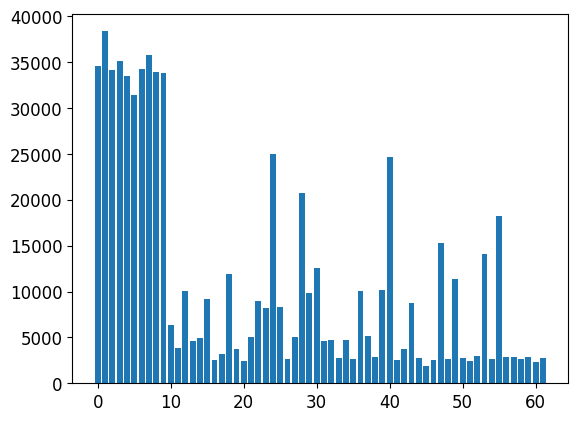

In [34]:
temp=np.array(y_train)
temp=pd.Series(temp)
temp=temp.value_counts()
temp=temp.sort_index()
plt.bar(temp.index,temp.values)

In [47]:
a=pd.Series(y_train.numpy()).value_counts().sort_index()
for i,j in zip(range(0,32),range(32,62)):
    print("{:2}:{:5} {:5}:{:5}   ".format(i,a[i],j,a[j]))

 0:34585    32: 4695   
 1:38374    33: 2771   
 2:34203    34: 4743   
 3:35143    35: 2701   
 4:33535    36:10033   
 5:31416    37: 5159   
 6:34232    38: 2854   
 7:35754    39:10177   
 8:33946    40:24631   
 9:33847    41: 2561   
10: 6407    42: 3687   
11: 3878    43: 8738   
12:10094    44: 2725   
13: 4562    45: 1896   
14: 4934    46: 2491   
15: 9182    47:15318   
16: 2517    48: 2645   
17: 3152    49:11418   
18:11946    50: 2749   
19: 3762    51: 2448   
20: 2468    52: 2994   
21: 5076    53:14105   
22: 9002    54: 2699   
23: 8237    55:18262   
24:24983    56: 2830   
25: 8347    57: 2910   
26: 2605    58: 2697   
27: 5073    59: 2822   
28:20764    60: 2365   
29: 9820    61: 2725   


### class 종류

In [11]:
labels = {}
for idx, label in enumerate(label_map):
    labels[idx] = chr(label)
print(labels)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j', 46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't', 56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z'}


### 데이터 시각화

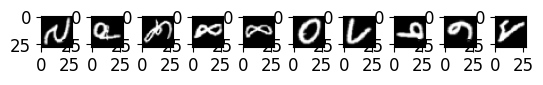

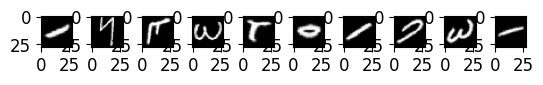

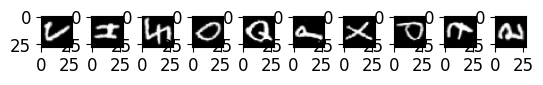

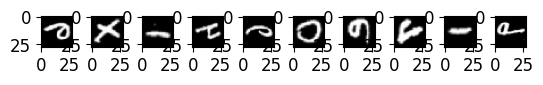

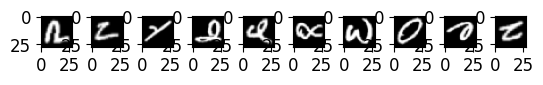

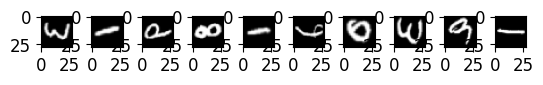

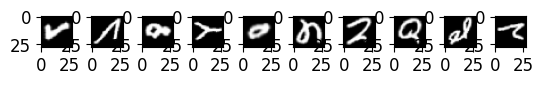

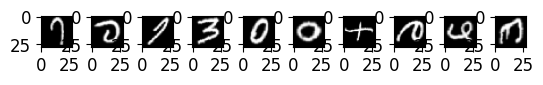

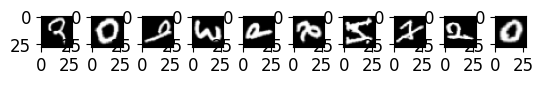

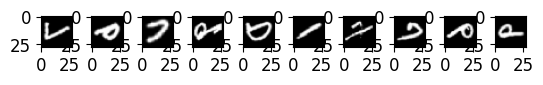

In [36]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
x_train_pd=pd.DataFrame(x_train.reshape(-1,784))
pd_plot(x_train_pd)

# 1-2) bymerge 

#### bymerge_pd_train=pd.read_csv('emnist-bymerge-train.csv',header=None)
#### bymerge_pd_test=pd.read_csv('emnist-bymerge-test.csv',header=None)

### 1-1)과 동일 문제(=메모리 부족으로 kernel이 죽는 문제)로 tensorflow_datasets의 data로 확인

In [13]:
((x_train,y_train), (x_test,y_test)), ds_info=tfds.load('emnist/bymerge',split=['train','test'],with_info=True,as_supervised=True,batch_size=-1)
label_map = pd.read_csv("emnist-bymerge-mapping.txt", delimiter = ' ', index_col=0, header=None).squeeze('columns')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\LG\tensorflow_datasets\emnist\bymerge\3.0.0.incomplete17TIJT\emnist-train.tfrecord*...:   0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\LG\tensorflow_datasets\emnist\bymerge\3.0.0.incomplete17TIJT\emnist-test.tfrecord*...:   0%…

Dataset emnist downloaded and prepared to C:\Users\LG\tensorflow_datasets\emnist\bymerge\3.0.0. Subsequent calls will reuse this data.


### 데이터 구성 확인

In [14]:
print(ds_info)

tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/bymerge/3.0.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST ByMerge
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_path='C:\\Users\\LG\\tensorflow_datasets\\emnist\\bymerge\\3.0.0',
    file_format=tfrecord,
    download_size=535.73 MiB,
    dataset_size=349.16 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=47),
    }),
    s

### 데이테 형태
#### 'image': Image(shape=(28, 28, 1), dtype=uint8), 28,28,1의 형태
#### 'label': ClassLabel(shape=(), dtype=int64, num_classes=47), 47개의 class
#### train : 697932개
#### test : 116323개


### class 별 갯수

<BarContainer object of 47 artists>

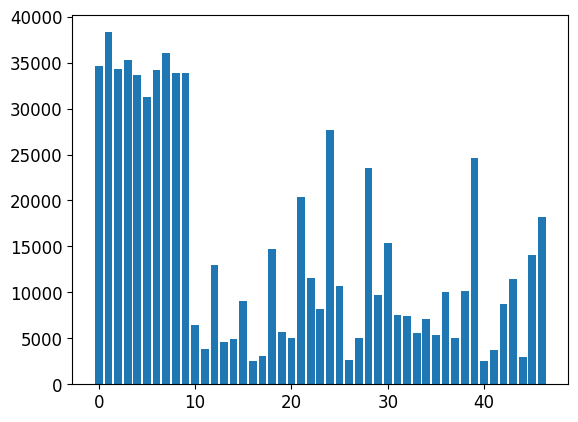

In [16]:
temp=np.array(y_train)
temp=pd.Series(temp)
temp=temp.value_counts()
temp=temp.sort_index()
plt.bar(temp.index,temp.values)

In [32]:
pd.Series(y_train.numpy()).value_counts().sort_index()

0     34618
1     38304
2     34307
3     35285
4     33656
5     31280
6     34150
7     36020
8     33924
9     33882
10     6411
11     3874
12    12963
13     4606
14     4925
15     9098
16     2534
17     3097
18    14733
19     5689
20     4998
21    20381
22    11612
23     8237
24    27664
25    10748
26     2603
27     5047
28    23509
29     9766
30    15388
31     7588
32     7403
33     5598
34     7092
35     5416
36    10009
37     5080
38    10152
39    24657
40     2535
41     3693
42     8682
43    11444
44     2966
45    14060
46    18248
Name: count, dtype: int64

### class 종류

In [17]:
labels = {}
for idx, label in enumerate(label_map):
    labels[idx] = chr(label)
print(labels) 

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


### 데이터 시각화

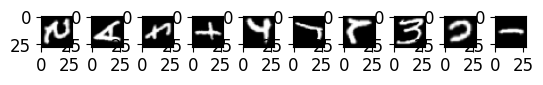

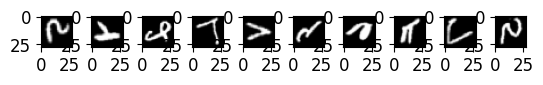

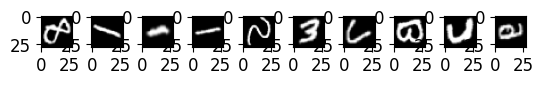

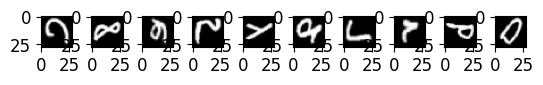

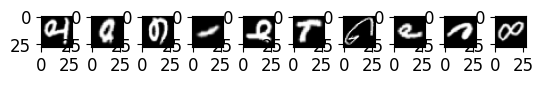

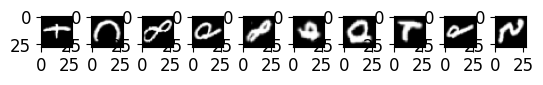

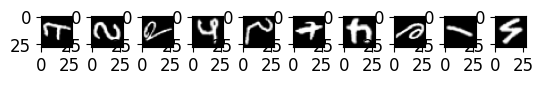

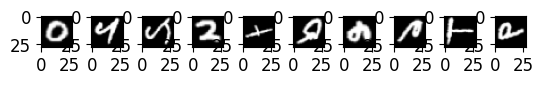

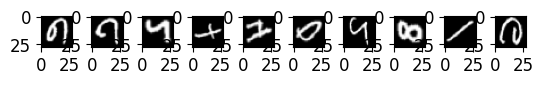

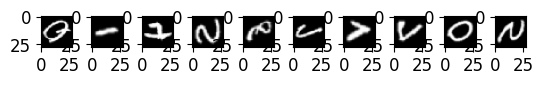

In [18]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
x_train_pd=pd.DataFrame(x_train.reshape(-1,784))
pd_plot(x_train_pd)

# 1-3) balance

### load_csv

In [51]:
balance_pd_train=pd.read_csv('emnist-balanced-train.csv',header=None)
balance_pd_test=pd.read_csv('emnist-balanced-test.csv',header=None)
balance_label_map = pd.read_csv("emnist-balanced-mapping.txt", delimiter = ' ', index_col=0, header=None).squeeze('columns')

### class 종류

In [52]:
balance_label_dic = {}
for index, label in enumerate(balance_label_map):
    balance_label_dic[index] = chr(label)
print(balance_label_dic)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


### 데이테 형태

In [53]:
balance_pd_train

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112795,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112796,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112797,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112798,31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
balance_pd_train.shape

(112800, 785)

#### 112800 rows × 785 columns의 형태를 가진다
#### col=0는 label을 의미한다
#### col=1~784는 이미지에 대한 data가 담겨있다

### split feature && label

In [55]:
balance_pd_train.rename(columns={0:'label'},inplace=True)
x_balance_train_pd=balance_pd_train.drop(columns=['label'])
x_balance_train_pd.columns=range(784)
y_balance_train_pd=pd.DataFrame(balance_pd_train.iloc[:]['label'],columns=['label'])

In [56]:
x_balance_train_pd

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
y_balance_train_pd

,label
0,45
1,36
2,43
3,15
4,4
...,...
112795,22
112796,17
112797,23
112798,31


### class별 개수

In [58]:
balance_count=y_balance_train_pd.value_counts()
balance_count.sort_index()

label
0        2400
1        2400
2        2400
3        2400
4        2400
5        2400
6        2400
7        2400
8        2400
9        2400
10       2400
11       2400
12       2400
13       2400
14       2400
15       2400
16       2400
17       2400
18       2400
19       2400
20       2400
21       2400
22       2400
23       2400
24       2400
25       2400
26       2400
27       2400
28       2400
29       2400
30       2400
31       2400
32       2400
33       2400
34       2400
35       2400
36       2400
37       2400
38       2400
39       2400
40       2400
41       2400
42       2400
43       2400
44       2400
45       2400
46       2400
Name: count, dtype: int64

### 데이터 시각화

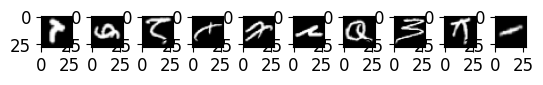

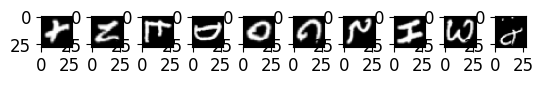

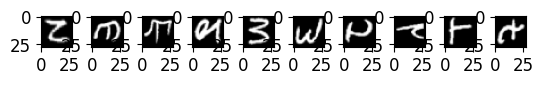

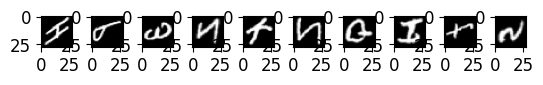

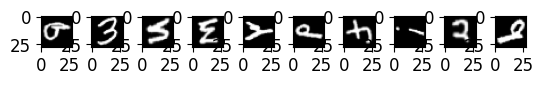

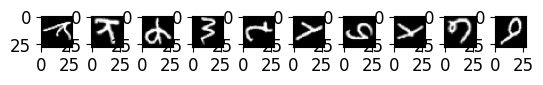

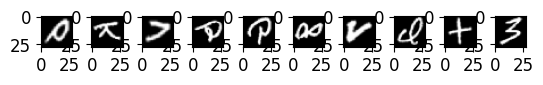

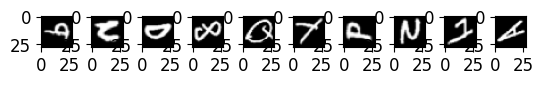

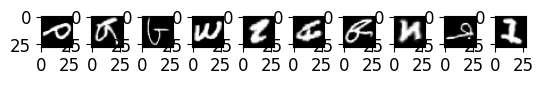

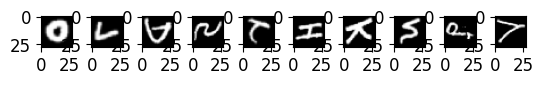

In [60]:
pd_plot(x_balance_train_pd)

### digits, letters, mnist 모두 확인 결과 balanced와 동일한 형태를 가진다.
### 따라서 이 3종류는 class종류와 개수만 나타낸다.

# 1-4) digits

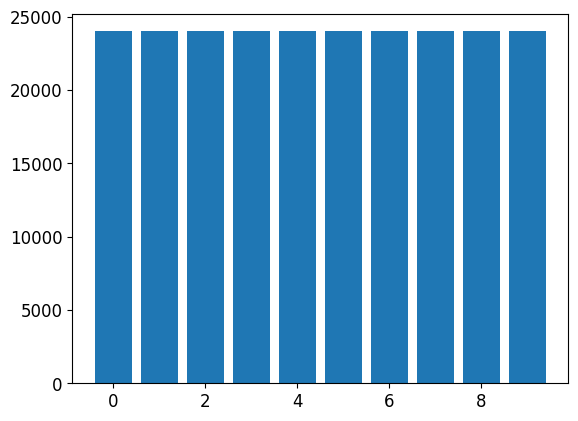

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}
0    24000
1    24000
2    24000
3    24000
4    24000
5    24000
6    24000
7    24000
8    24000
9    24000
Name: count, dtype: int64


In [70]:
x_train_full=pd.read_csv('emnist-digits-train.csv',header=None)
label_map = pd.read_csv("emnist-digits-mapping.txt", delimiter = ' ', index_col=0, header=None).squeeze('columns')
y_train=x_train_full.iloc[:,0]
temp=np.array(y_train)
temp=pd.Series(temp)
temp=temp.value_counts()
temp=temp.sort_index()
plt.bar(temp.index,temp.values)
plt.show()
labels = {}
for idx, label in enumerate(label_map):
    labels[idx] = chr(label)
print(labels)
print(temp)

# 1-5) letters

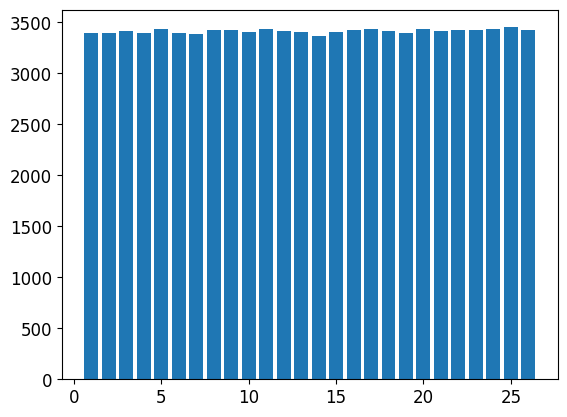

{0: '\x01', 1: '\x02'}
1     3396
2     3396
3     3419
4     3398
5     3437
6     3394
7     3385
8     3424
9     3428
10    3402
11    3438
12    3415
13    3402
14    3365
15    3408
16    3430
17    3435
18    3419
19    3392
20    3436
21    3419
22    3422
23    3423
24    3437
25    3453
26    3427
Name: count, dtype: int64


In [73]:
x_train_full=pd.read_csv('emnist-letters-train.csv',header=None)
label_map = pd.read_csv("emnist-letters-mapping.txt", delimiter = ' ', index_col=0, header=None).squeeze('columns')
y_train=x_train_full.iloc[:,0]
temp=np.array(y_train)
temp=pd.Series(temp)
temp=temp.value_counts()
temp=temp.sort_index()
plt.bar(temp.index,temp.values)
plt.show()
labels = {}
for idx, label in enumerate(label_map):
    labels[idx] = chr(label)
print(labels)
print(temp)

# 1-6) mnist

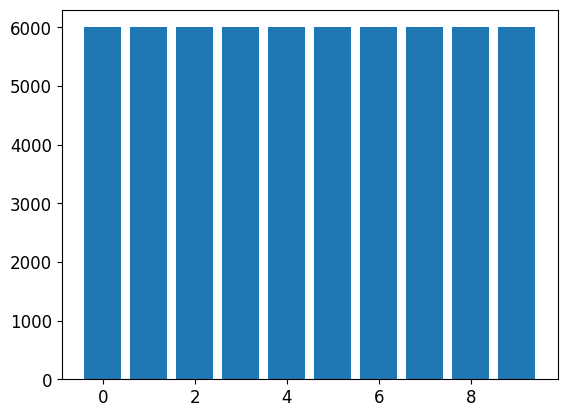

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64


In [74]:
x_train_full=pd.read_csv('emnist-mnist-train.csv',header=None)
label_map = pd.read_csv("emnist-mnist-mapping.txt", delimiter = ' ', index_col=0, header=None).squeeze('columns')
y_train=x_train_full.iloc[:,0]
temp=np.array(y_train)
temp=pd.Series(temp)
temp=temp.value_counts()
temp=temp.sort_index()
plt.bar(temp.index,temp.values)
plt.show()
labels = {}
for idx, label in enumerate(label_map):
    labels[idx] = chr(label)
print(labels)
print(temp)

### 0~9, 알파벳 대소문자로 총 62개의 값을 분류하는게 목표인데 위 데이터들 중 62개를 분류하는 모델은
### byclass가 유일함으로 tfds의 byclass를 dataset으로 선택한다.

### 이후 학습을 진행 시 너무 커서 모델이 돌아가지않고 에러가 뜨는 현상이 발생하였다.
### tf.data.Dataset형태로 진행하고자 하며 실습실 컴퓨터는 csv그래로 읽어오는게 가능하므로
### 최종적으로 사용하는 dataset은 byclass.csv이다

### byclass.csv도 balanced와 형태가 라벨의 갯수 뺴고 동일하므로 간단히만 나타낸다.

# 최종 사용 dataset : byclass(csv)

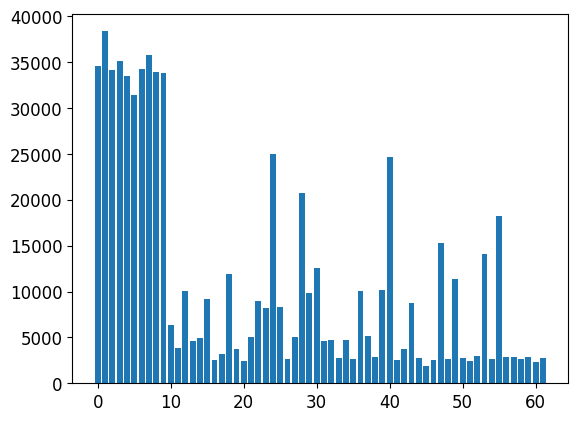

train data's shape :  (697932, 785)
test data's shape :  (116323, 785)
class type
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j', 46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't', 56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z'}
class#
0     34585
1     38374
2     34203
3     35143
4     33535
      ...  
57     2910
58     2697
59     2822
60     2365
61     2725
Name: count, Length: 62, dtype: int64
plot some image


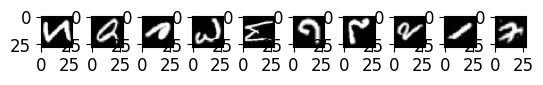

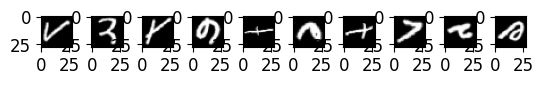

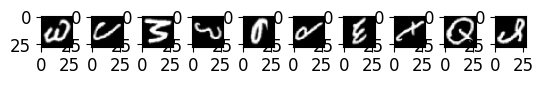

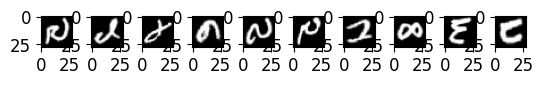

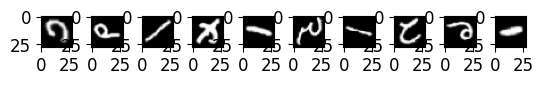

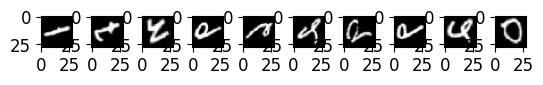

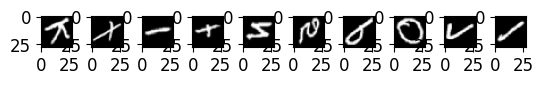

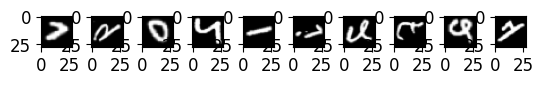

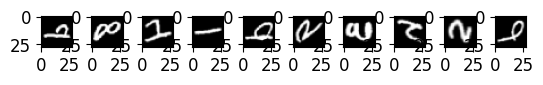

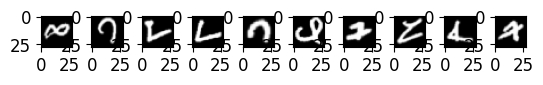

In [89]:
x_train_full=pd.read_csv('emnist-byclass-train.csv',header=None)
x_test_full=pd.read_csv('emnist-byclass-test.csv',header=None)
label_map = pd.read_csv("emnist-byclass-mapping.txt", delimiter = ' ', index_col=0, header=None).squeeze('columns')
x_train=x_train_full.iloc[:,1:]
y_train=x_train_full.iloc[:,0]
temp=np.array(y_train)
temp=pd.Series(temp)
temp=temp.value_counts()
temp=temp.sort_index()
plt.bar(temp.index,temp.values)
plt.show()
print("train data's shape : ",x_train_full.shape)
print("test data's shape : ",x_test_full.shape)
labels = {}
for idx, label in enumerate(label_map):
    labels[idx] = chr(label)
print("class type")
print(labels)
print("class#")
print(temp)
print("plot some image")
pd_plot(x_train)